In [40]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import simulation, simulation_line, visualize, simulation_lorenz, combine_simulations, visualize, load_config
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The goal in this notebook is to study the impact of combining different shapes on the DSA metric. The idea is to create a dataset with different shapes and see how the DSA metric behaves when combining them.

## Parameters

#### Lorenz attractor simulation parameters

For each configuration, we simulate with $num\_samples$ possible initializations accross $num\_steps$ 

Parameters to compute the dissimilarity matrices and the Procrustes Alignment over Vector Fields, according to [1]

In [41]:
config = load_config('../config.yaml')

## Compositionality

We here want to analyse the evolution of the dissimilarity as a function of the number of shared motifs

### Generation of the elementary motifs

We create here elementary motifs which will be repurposed as a basis for compositional motifs later

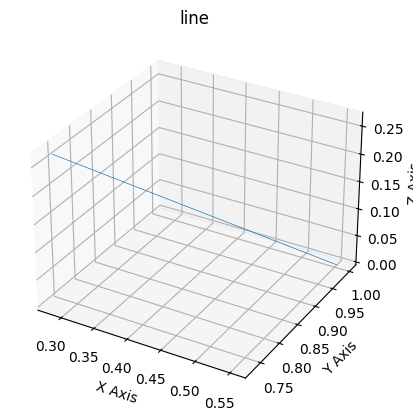

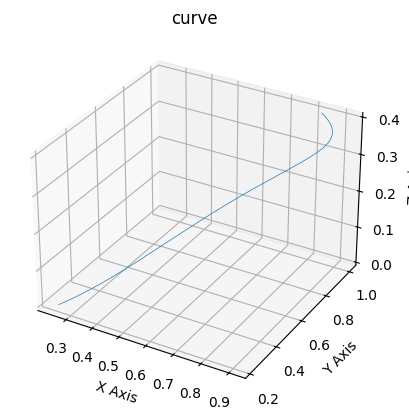

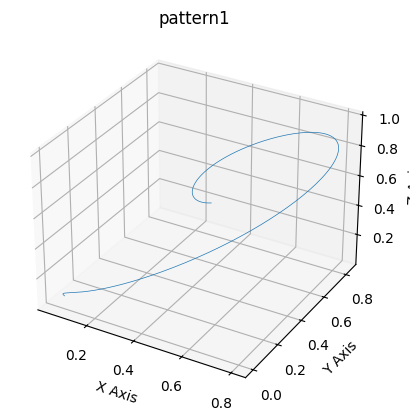

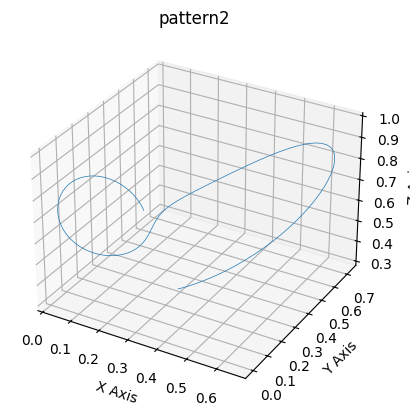

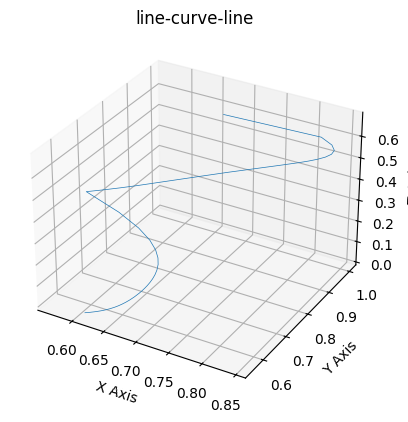

In [42]:
# Define parameters
dt = config['simulations']['dt']
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']

# Run simulations line
simulations_line = simulation_line(num_steps, num_samples)

# Run simulations curve
simulations_curve = simulation_lorenz(dt, lorenz_parameters['one_attractor'][1], num_samples, num_steps)

# Run simulations Pattern1
simulations_pattern1 = simulation_lorenz(dt, lorenz_parameters['two_stable_attractors'][0], num_samples, num_steps)

# Run simulations Pattern2
simulations_pattern2 = simulation_lorenz(dt, lorenz_parameters['two_stable_attractors'][2], num_samples, num_steps)

# Run simulations line-curve-line-curve
combined_simulations_line_curve_line = combine_simulations([simulations_line, simulations_curve, np.flip(simulations_line, axis=0), np.flip(simulations_curve, axis=0)], method='attach')


# Visualize the simulations
visualize([simulations_line[0]],"line")
visualize([simulations_curve[0]],"curve")
visualize([simulations_pattern1[0]], "pattern1")
visualize([simulations_pattern2[0]], "pattern2")
visualize([combined_simulations_line_curve_line[0]],"line-curve-line")

### Generation of the possible compositional motifs

We here genetate all the possible permutations of $3$ different motifs among the $5$ elementary motifs. We hence have $5 \times 4 \times 3 = 60$ possible compositions.

In [43]:
combine_pattern_curve = combine_simulations([simulations_line, simulations_pattern1], method='attach')

In [44]:
motif_basis = [simulations_line, simulations_curve, simulations_pattern1,simulations_pattern2,combined_simulations_line_curve_line]
motif_names = ['Line', 'Curve', 'Pattern1', 'Pattern2','Line-Curve-Line-Curve']
motif_dict = {motif_names[i]: motif_basis[i] for i in range(len(motif_basis))}
all_simulations_length_3 = list(permutations(motif_names, 3))

In [45]:
all_simulations_combined = {permutation: combine_simulations([motif_dict[permutation[0]], motif_dict[permutation[1]], motif_dict[permutation[2]]],method='attach') for permutation in all_simulations_length_3}

One out of $60$ possible combinations

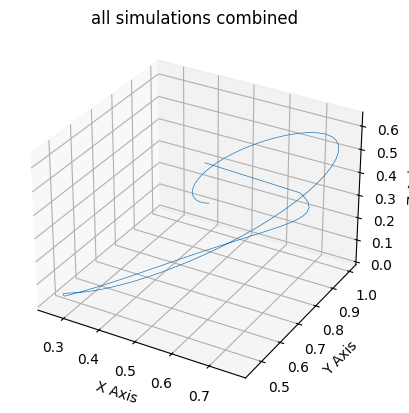

In [46]:
visualize([list(all_simulations_combined.values())[0][0]],"all simulations combined")

### DSA computation

We here measure the similarity between the 60 compositional motifs : 
- the three independant patterns, namely a line, curve and a lorenz pattern
- A combination of each 

In [47]:
model = list(all_simulations_combined.values())
model_names = list(all_simulations_combined.keys())

In [48]:
procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
dissimilarities_pa = np.empty((len(model),len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        dissimilarities_pa[i,j] = 1-procrustes_measure(model[i], model[j])

In [49]:
cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
dissimilarities_cka= np.empty((len(model), len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        dissimilarities_cka[i, j] = 1-cka_measure(model[i], model[j])

arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.8019342350779493 0.6402704198152697 0.19806576492205075
arccos score: 0.6487938466755518 0.8647979960834972 0.35120615332444816
arccos score: 0.6934863622210182 0.8044794600880316 0.3065136377789818
arccos score: 0.5640514715584369 0.9715122261011074 0.43594852844156307
arccos score: 0.6782717433712768 0.8253882267846344 0.3217282566287232
arccos score: 0.6448855790000424 0.869922764034485 0.3551144209999576
arccos score: 0.5921095792504573 0.9371221888844704 0.40789042074954274
arccos score: 0.6529898606420573 0.8592708697267883 0.34701013935794267
arccos score: 0.4959546099408073 1.0518625001311548 0.5040453900591927
arccos score: 0.8387158407591895 0.575875523399248 0.16128415924081052
arccos score: 0.6923017715234707 0.8061223539502752 0.3076982284765293
arccos score: 0.15366751311696503 1.416517518871931 0.846332486883035
arccos score: 0.03570799484113918 1.5350807392851349 0.9642920051588608
arccos score: 0.0061503

In [50]:
path = "../data/dsa_results/50_17_11.csv"

df = pd.read_csv(path)
df.rename(
    columns={"number of shared elements": "number_of_shared_elements"}, inplace=True
)
data_all = (
    df.dropna()
)  # plot on a single plot the Median similarity vs Number of shared elements for pair  (n_delay, delay_interval)
dissimilarities_dsa = (
    data_all.groupby(["number_of_shared_elements"])["similarity"].mean().reset_index()
)

### Dissimilarity VS number of shared elements

We group here the compositional motifs by number of shared elements

In [52]:
grouped_by_shared_elements_unordered = {i:[] for i in range(4)}
for comp_motif_1 in model_names:
    for comp_motif_2 in model_names:
        if model_names.index(comp_motif_1) != model_names.index(comp_motif_2):
            set_1 = set(comp_motif_1)
            set_2 = set(comp_motif_2)
            grouped_by_shared_elements_unordered[len(set_1.intersection(set_2))].extend([(comp_motif_1, comp_motif_2)])

In [53]:
dissimilarities_pa_grouped_by_shared_elements_unordered = {i:[] for i in range(1,4)}
for key in grouped_by_shared_elements_unordered:
    for tuple1, tuple2 in grouped_by_shared_elements_unordered[key]:
        similarity_pa = dissimilarities_pa[model_names.index(tuple1), model_names.index(tuple2)]
        dissimilarities_pa_grouped_by_shared_elements_unordered[key].append(similarity_pa)

dissimilarities_cka_grouped_by_shared_elements_unordered = {i: [] for i in range(1, 4)}
for key in grouped_by_shared_elements_unordered:
    for tuple1, tuple2 in grouped_by_shared_elements_unordered[key]:
        similarity_cka = dissimilarities_cka[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_cka_grouped_by_shared_elements_unordered[key].append(similarity_cka)

In [54]:
median_dissimilarities_pa = {
    key: np.median(value)
    for key, value in dissimilarities_pa_grouped_by_shared_elements_unordered.items()
}
median_dissimilarities_cka = {
    key: np.median(value)
    for key, value in dissimilarities_cka_grouped_by_shared_elements_unordered.items()
}

In [59]:
dissimilarity_pa = pd.DataFrame({"number_of_shared_elements": list(median_dissimilarities_pa.keys()), "similarity": list(median_dissimilarities_pa.values())})
dissimilarity_cka = pd.DataFrame({"number_of_shared_elements": list(median_dissimilarities_cka.keys()), "similarity": list(median_dissimilarities_cka.values())})

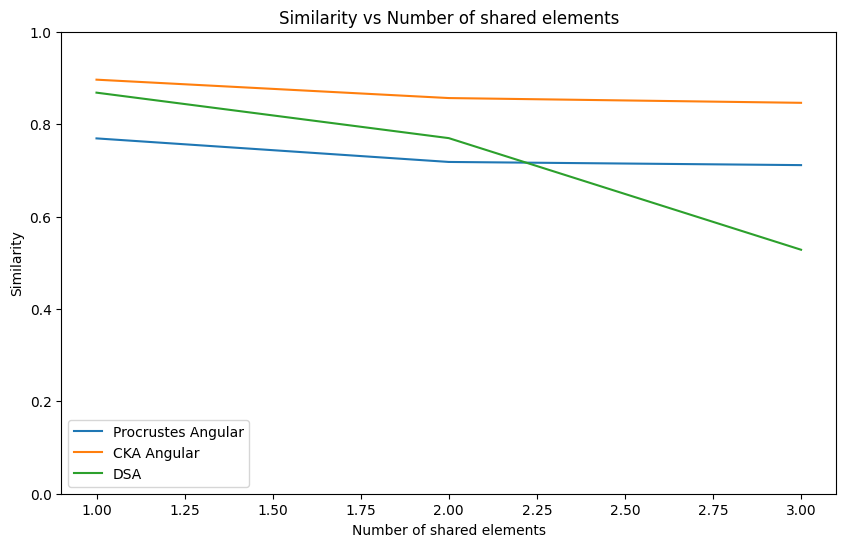

In [61]:
# plot dissimilarity as a function of number of shared elements for pa, cka and dsa and fix y axis between 0 and 1
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="number_of_shared_elements",
    y="similarity",
    data=dissimilarity_pa,
    label="Procrustes Angular",
)
sns.lineplot(
    x="number_of_shared_elements",
    y="similarity",
    data=dissimilarity_cka,
    label="CKA Angular",
)
sns.lineplot(
    x="number_of_shared_elements",
    y="similarity",
    data=dissimilarities_dsa,
    label="DSA",
)
plt.xlabel("Number of shared elements")
plt.ylabel("Similarity")
plt.title("Similarity vs Number of shared elements")
plt.ylim(0, 1)
plt.legend()
plt.show()


### Ordered

In [62]:
path = "../data/dsa_results/50_17_11_ordered.csv"

df = pd.read_csv(path)
df.rename(
    columns={"number of shared elements": "number_of_shared_elements"}, inplace=True
)
data_all = (
    df.dropna()
)  # plot on a single plot the Median similarity vs Number of shared elements for pair  (n_delay, delay_interval)
dissimilarities_dsa = (
    data_all.groupby(["number_of_shared_elements"])["similarity"].mean().reset_index()
)

In [67]:
def same_order(comp_motif_1, comp_motif_2) -> bool:
    return len(
        [i for i in range(len(comp_motif_1)) if comp_motif_1[i] == comp_motif_2[i]]
    )

In [68]:
grouped_by_shared_elements_ordered = {i: [] for i in range(1,4)}
for comp_motif_1 in model_names:
    for comp_motif_2 in model_names:
        grouped_by_shared_elements_ordered[same_order(comp_motif_1, comp_motif_2)].extend(
            [(comp_motif_1, comp_motif_2)]
        )

KeyError: 0

In [69]:
dissimilarities_pa_grouped_by_shared_elements_ordered = {i: [] for i in range(1, 4)}
for key in grouped_by_shared_elements_ordered:
    for tuple1, tuple2 in grouped_by_shared_elements_ordered[key]:
        similarity_pa = dissimilarities_pa[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_pa_grouped_by_shared_elements_ordered[key].append(
            similarity_pa
        )

dissimilarities_cka_grouped_by_shared_elements_ordered = {i: [] for i in range(1, 4)}
for key in grouped_by_shared_elements_ordered:
    for tuple1, tuple2 in grouped_by_shared_elements_ordered[key]:
        similarity_cka = dissimilarities_cka[
            model_names.index(tuple1), model_names.index(tuple2)
        ]
        dissimilarities_cka_grouped_by_shared_elements_ordered[key].append(
            similarity_cka
        )

In [70]:
median_dissimilarities_pa_ordered = {
    key: np.median(value)
    for key, value in dissimilarities_pa_grouped_by_shared_elements_ordered.items()
}
median_dissimilarities_cka_ordered = {
    key: np.median(value)
    for key, value in dissimilarities_cka_grouped_by_shared_elements_ordered.items()
}

In [71]:
dissimilarity_pa = pd.DataFrame(
    {
        "number_of_shared_elements": list(median_dissimilarities_pa_ordered.keys()),
        "similarity": list(median_dissimilarities_pa_ordered.values()),
    }
)
dissimilarity_cka = pd.DataFrame(
    {
        "number_of_shared_elements": list(median_dissimilarities_cka_ordered.keys()),
        "similarity": list(median_dissimilarities_cka_ordered.values()),
    }
)

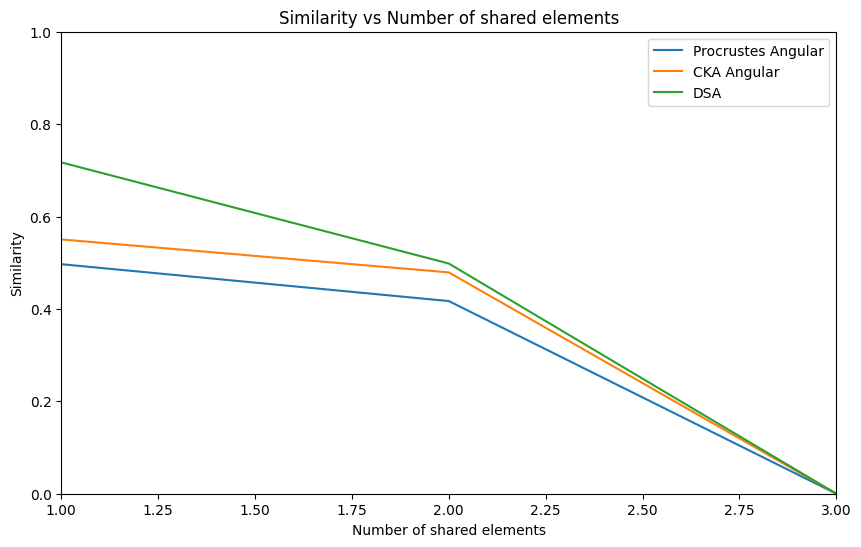

In [74]:
# plot dissimilarity as a function of number of shared elements for pa, cka and dsa and fix y axis between 0 and 1
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="number_of_shared_elements",
    y="similarity",
    data=dissimilarity_pa,
    label="Procrustes Angular",
)
sns.lineplot(
    x="number_of_shared_elements",
    y="similarity",
    data=dissimilarity_cka,
    label="CKA Angular",
)
sns.lineplot(
    x="number_of_shared_elements",
    y="similarity",
    data=dissimilarities_dsa,
    label="DSA",
)
plt.xlabel("Number of shared elements")
plt.ylabel("Similarity")
plt.title("Similarity vs Number of shared elements")
plt.xlim(1, 3)
plt.ylim(0, 1)
plt.legend()
plt.show()

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 